# Spark Collaborative Filtering (ALS) Deep Dive

## Goals

Spark MLlib provides a collaborative filtering algorithm that can be used for training a matrix factorization model, which predicts explicit or implicit ratings of users on items for recommendations.

This notebook presents a deep dive into the Spark collaborative filtering algorithm.

## Theoretical Aspects

### Matrix factorization algorithm

#### Matrix factorization for collaborative filtering problem

Matrix factorization is a common technique used in recommendation tasks. Basically, a matrix factorization algorithm tries to find latent factors that represent intrinsic user and item attributes in a lower dimension. That is,

$$\hat r_{u,i} = q_{i}^{T}p_{u}$$

where $\hat r_{u,i}$ is the predicted ratings for user $u$ and item $i$, and $q_{i}^{T}$ and $p_{u}$ are latent factors for item and user, respectively. The challenge to the matrix factorization problem is to find $q_{i}^{T}$ and $p_{u}$. This is achieved by methods such as matrix decomposition. A learning approach is therefore developed to converge the decomposition results close to the observed ratings as much as possible. Furthermore, to avoid overfitting issue, the learning process is regularized. For example, a basic form of such matrix factorization algorithm is represented as below.

$$\min\sum(r_{u,i} - q_{i}^{T}p_{u})^2 + \lambda(||q_{i}||^2 + ||p_{u}||^2)$$

where $\lambda$ is a the regularization parameter. 

In case explict ratings are not available, implicit ratings which are usually derived from users' historical interactions with the items (e.g., clicks, views, purchases, etc.). To account for such implicit ratings, the original matrix factorization algorithm can be formulated as 

$$\min\sum c_{u,i}(p_{u,i} - q_{i}^{T}p_{u})^2 + \lambda(||q_{i}||^2 + ||p_{u}||^2)$$

where $c_{u,i}=1+\alpha r_{u,i}$ and $p_{u,i}=1$ if $r_{u,i}>0$ and $p_{u,i}=0$ if $r_{u,i}=0$. $r_{u,i}$ is a numerical representation of users' preferences (e.g., number of clicks, etc.). 

#### Alternating Least Square (ALS)

Owing to the term of $q_{i}^{T}p_{u}$ the loss function is non-convex. Gradient descent method can be applied but this will incur expensive computations. An Alternating Least Square (ALS) algorithm was therefore developed to overcome this issue. 

The basic idea of ALS is to learn one of $q$ and $p$ at a time for optimization while keeping the other as constant. This makes the objective at each iteration convex and solvable. The alternating between $q$ and $p$ stops when there is convergence to the optimal. It is worth noting that this iterative computation can be parallelised and/or distributed, which makes the algorithm desirable for use cases where the dataset is large and thus the user-item rating matrix is super sparse (as is typical in recommendation scenarios). A comprehensive discussion of ALS and its distributed computation can be found [here](http://stanford.edu/~rezab/classes/cme323/S15/notes/lec14.pdf).

### Spark Mllib implementation

The matrix factorization algorithm is available as `ALS` module in [Spark `ml`](https://spark.apache.org/docs/latest/ml-collaborative-filtering.html) for DataFrame or [Spark `mllib`](https://spark.apache.org/docs/latest/mllib-collaborative-filtering.html) for RDD. 

* The uniqueness of ALS implementation is that it distributes the matrix factorization model training by using "Alternating Least Square" method. 
* In the training method, there are parameters that can be selected to control the model performance.
* Both explicit and implicit ratings are supported by Spark ALS model.

### Spark ALS based MovieLens recommender

In the following code, the MovieLens-100K dataset is used to illustrate the ALS algorithm in Spark.

**Note**: This notebook requires a PySpark environment to run properly. Please follow the steps in [SETUP.md](https://github.com/Microsoft/Recommenders/blob/master/SETUP.md#dependencies-setup) to install the PySpark environment.

In [1]:
# set the environment path to find Recommenders
import sys
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import sys
import pandas as pd

import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
import pyspark.sql.functions as F
from pyspark.sql.functions import col
from pyspark.ml.tuning import CrossValidator
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import FloatType, IntegerType, LongType

from recommenders.datasets import movielens
from recommenders.utils.spark_utils import start_or_get_spark
from recommenders.evaluation.spark_evaluation import SparkRankingEvaluation, SparkRatingEvaluation
from recommenders.tuning.parameter_sweep import generate_param_grid
from recommenders.datasets.spark_splitters import spark_random_split

print("System version: {}".format(sys.version))
print("Pandas version: {}".format(pd.__version__))
print("PySpark version: {}".format(pyspark.__version__))

System version: 3.8.8 (default, Apr 13 2021, 12:59:45) 
[Clang 10.0.0 ]
Pandas version: 1.4.1
PySpark version: 3.2.1


Data column names

In [2]:
MOVIELENS_DATA_SIZE = "100k"

COL_USER = "UserId"
COL_ITEM = "MovieId"
COL_RATING = "Rating"
COL_PREDICTION = "prediction"
COL_TIMESTAMP = "Timestamp"

In [3]:
schema = StructType(
    (
        StructField(COL_USER, IntegerType()),
        StructField(COL_ITEM, IntegerType()),
        StructField(COL_RATING, FloatType()),
        StructField(COL_TIMESTAMP, LongType()),
    )
)

Model hyper parameters - these parameters are selected with reference to the benchmarking results [here](http://mymedialite.net/examples/datasets.html).

In [4]:
RANK = 10
MAX_ITER = 15
REG_PARAM = 0.05

Number of recommended items

In [5]:
K = 10

Initialize a Spark session.

In [6]:
spark = start_or_get_spark("ALS Deep Dive", memory="16g")

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/10/04 00:46:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


#### Load and prepare data

Data is read from csv into a Spark DataFrame.

In [7]:
dfs = movielens.load_spark_df(spark=spark, size=MOVIELENS_DATA_SIZE, schema=schema)

100%|█████████████████████████████████████| 4.81k/4.81k [00:01<00:00, 4.01kKB/s]


In [8]:
dfs.show(5)

+------+-------+------+---------+
|UserId|MovieId|Rating|Timestamp|
+------+-------+------+---------+
|   196|    242|   3.0|881250949|
|   186|    302|   3.0|891717742|
|    22|    377|   1.0|878887116|
|   244|     51|   2.0|880606923|
|   166|    346|   1.0|886397596|
+------+-------+------+---------+
only showing top 5 rows



Data is then randomly split by 80-20 ratio for training and testing.

In [9]:
dfs_train, dfs_test = spark_random_split(dfs, ratio=0.75, seed=42)

In [10]:
type(dfs_train)

pyspark.sql.dataframe.DataFrame

In [11]:
dfs_train[COL_RATING]
dfs_train.printSchema()
dfs_train.select(COL_RATING).show(5)
dfs_train.toPandas().head(5)

root
 |-- UserId: integer (nullable = true)
 |-- MovieId: integer (nullable = true)
 |-- Rating: float (nullable = true)
 |-- Timestamp: long (nullable = true)



+------+
|Rating|
+------+
|   5.0|
|   3.0|
|   3.0|
|   3.0|
|   5.0|
+------+
only showing top 5 rows



,UserId,MovieId,Rating,Timestamp
0,1,1,5.0,874965758
1,1,2,3.0,876893171
2,1,4,3.0,876893119
3,1,5,3.0,889751712
4,1,6,5.0,887431973


#### Train a movielens model 

It is worth noting that Spark ALS model allows dropping cold users to favor a robust evaluation with the testing data. In case there are cold users, Spark ALS implementation allows users to drop cold users in order to make sure evaluations on the prediction results are sound.

In [12]:
als = ALS(
    maxIter=MAX_ITER, 
    rank=RANK,
    regParam=REG_PARAM, 
    userCol=COL_USER, 
    itemCol=COL_ITEM, 
    ratingCol=COL_RATING, 
    coldStartStrategy="drop"
)

model = als.fit(dfs_train)

22/10/04 00:47:10 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/10/04 00:47:10 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
22/10/04 00:47:11 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


#### Prediction with the model

The trained model can be used to predict ratings with a given test data.

In [13]:
dfs_pred = model.transform(dfs_test).drop(COL_RATING)

With the prediction results, the model performance can be evaluated.

In [14]:
evaluations = SparkRatingEvaluation(
    dfs_test, 
    dfs_pred,
    col_user=COL_USER,
    col_item=COL_ITEM,
    col_rating=COL_RATING,
    col_prediction=COL_PREDICTION
)

print(
    "RMSE score = {}".format(evaluations.rmse()),
    "MAE score = {}".format(evaluations.mae()),
    "R2 score = {}".format(evaluations.rsquared()),
    "Explained variance score = {}".format(evaluations.exp_var()),
    sep="\n"
)

/Users/chandrasingh/opt/anaconda3/envs/reco/lib/python3.8/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


RMSE score = 0.9683063606464523
MAE score = 0.7535616298667033
R2 score = 0.2590825012455288
Explained variance score = 0.26461688837894515


Oftentimes ranking metrics are also of interest to data scientists. Note usually ranking metrics apply to the scenario of recommending a list of items. In our case, the recommended items should be different from those that have been rated by the users. 

In [15]:
# Get the cross join of all user-item pairs and score them.
users = dfs_train.select(COL_USER).distinct()
items = dfs_train.select(COL_ITEM).distinct()
user_item = users.crossJoin(items)
dfs_pred = model.transform(user_item)

In [16]:
# Fix the ambiguous col exception
dfs1 = dfs_pred.alias("pred")
dfs2 = dfs_train.alias("train")

In [17]:
# Remove seen items.
# dfs_pred_exclude_train = dfs_pred.alias("pred").join(
#     dfs_train.alias("train"),
#     (dfs_pred[COL_USER] == dfs_train[COL_USER]) & (dfs_pred[COL_ITEM] == dfs_train[COL_ITEM]),
#     how='outer'
# )
dfs_pred_exclude_train = dfs1.join(dfs2,
    (dfs1[COL_USER] == dfs2[COL_USER]) & (dfs1[COL_ITEM] == dfs2[COL_ITEM]),
    how='outer'
)

dfs_pred_final = dfs_pred_exclude_train.filter(dfs_pred_exclude_train["train.Rating"].isNull()) \
    .select('pred.' + COL_USER, 'pred.' + COL_ITEM, 'pred.' + "prediction")

dfs_pred_final.show()

+------+-------+----------+
|UserId|MovieId|prediction|
+------+-------+----------+
|     1|     46|  3.589898|
|     1|    255| 2.7095366|
|     1|    284|  3.043392|
|     1|    285|  4.632741|
|     1|    318|  4.467332|
|     1|    329| 3.7131171|
|     1|    335| 3.3609362|
|     1|    353|  2.497454|
|     1|    371| 2.7252212|
|     1|    372|  4.158202|
|     1|    381|  3.781853|
|     1|    391| 2.1080215|
|     1|    409| 2.6763377|
|     1|    413|  3.251512|
|     1|    417| 2.5076287|
|     1|    440|0.72083133|
|     1|    449| 3.2115946|
|     1|    463|  4.025364|
|     1|    480|  4.459408|
|     1|    488| 3.5710163|
+------+-------+----------+
only showing top 20 rows



In [18]:
evaluations = SparkRankingEvaluation(
    dfs_test, 
    dfs_pred_final,
    col_user=COL_USER,
    col_item=COL_ITEM,
    col_rating=COL_RATING,
    col_prediction=COL_PREDICTION,
    k=K
)

print(
    "Precision@k = {}".format(evaluations.precision_at_k()),
    "Recall@k = {}".format(evaluations.recall_at_k()),
    "NDCG@k = {}".format(evaluations.ndcg_at_k()),
    "Mean average precision = {}".format(evaluations.map_at_k()),
    sep="\n"
)

Precision@k = 0.042629904559915166
Recall@k = 0.013265474380586673
NDCG@k = 0.03691206373345781
Mean average precision = 0.003345435993411571


#### Fine tune the model

Prediction performance of a Spark ALS model is often affected by the parameters

|Parameter|Description|Default value|Notes|
|-------------|-----------------|------------------|-----------------|
|`rank`|Number of latent factors|10|The larger the more intrinsic factors considered in the factorization modeling.|
|`regParam`|Regularization parameter|1.0|The value needs to be selected empirically to avoid overfitting.|
|`maxIters`|Maximum number of iterations|10|The more iterations the better the model converges to the optimal point.|

It is always a good practice to start model building with default parameter values and then sweep the parameter in a range to find the optimal combination of parameters. The following parameter set is used for training ALS models for comparison study purposes.

In [19]:
param_dict = {
    "rank": [10, 15, 20],
    "regParam": [0.001, 0.1, 1.0]
}

Generate a dictionary for each parameter combination which can then be fed into model training.

In [20]:
param_grid = generate_param_grid(param_dict)

Train models with parameters specified in the parameter grid. Evaluate the model with, for example, the RMSE metric, and then record the metrics for visualization.

In [21]:
rmse_score = []

for g in param_grid:
    als = ALS(        
        userCol=COL_USER, 
        itemCol=COL_ITEM, 
        ratingCol=COL_RATING, 
        coldStartStrategy="drop",
        **g
    )
    
    model = als.fit(dfs_train)
    
    dfs_pred = model.transform(dfs_test).drop(COL_RATING)
    
    evaluations = SparkRatingEvaluation(
        dfs_test, 
        dfs_pred,
        col_user=COL_USER,
        col_item=COL_ITEM,
        col_rating=COL_RATING,
        col_prediction=COL_PREDICTION
    )

    rmse_score.append(evaluations.rmse())
    
rmse_score = [float('%.4f' % x) for x in rmse_score]
rmse_score_array = np.reshape(rmse_score, (len(param_dict["rank"]), len(param_dict["regParam"]))) 

In [22]:
rmse_df = pd.DataFrame(data=rmse_score_array, index=pd.Index(param_dict["rank"], name="rank"), 
                       columns=pd.Index(param_dict["regParam"], name="reg. parameter"))
rmse_df

reg. parameter,0.001,0.100,1.000
rank,,,
10,1.3260,0.9275,1.3693
15,1.4796,0.9277,1.3693
20,1.5679,0.9277,1.3693


<AxesSubplot:xlabel='reg. parameter', ylabel='rank'>

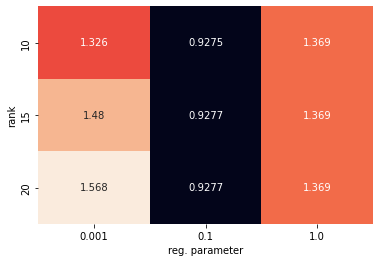

In [23]:
fig, ax = plt.subplots()
sns.heatmap(rmse_df, cbar=False, annot=True, fmt=".4g")

The calculated RMSE scores can be visualized to comparatively study how model performance is affected by different parameters.

It can be seen from this visualization that RMSE first decreases and then increases as rank increases, due to overfitting. When the rank equals 20 and the regularization parameter equals 0.1, the model achieves the lowest RMSE score.

#### Top K recommendation

##### Top k for all users (items)

In [24]:
dfs_rec = model.recommendForAllUsers(10)

/Users/chandrasingh/opt/anaconda3/envs/reco/lib/python3.8/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [25]:
dfs_rec.show(10)

+------+--------------------+
|UserId|     recommendations|
+------+--------------------+
|     1|[{1536, 3.8911994...|
|     3|[{1536, 3.106384}...|
|     6|[{1536, 3.7354307...|
|    12|[{1536, 4.4471893...|
|    13|[{1536, 3.399742}...|
|    16|[{1536, 4.565807}...|
|    20|[{1536, 3.3140035...|
|    22|[{1536, 3.7392454...|
|    26|[{1536, 3.1729918...|
|    27|[{1536, 3.4825766...|
+------+--------------------+
only showing top 10 rows



##### Top k for a selected set of users (items)

In [26]:
users = dfs_train.select(als.getUserCol()).distinct().limit(3)

dfs_rec_subset = model.recommendForUserSubset(users, 10)

In [27]:
dfs_rec_subset.show(10)

+------+--------------------+
|UserId|     recommendations|
+------+--------------------+
|   471|[{1536, 3.3287528...|
|   463|[{1536, 3.1125834...|
|   148|[{1536, 3.9075737...|
+------+--------------------+



##### Run-time considerations for top-k recommendations

It is worth noting that usually computing the top-k recommendations for all users is the bottleneck of the whole pipeline (model training and scoring) of an ALS based recommendation system. This is because
* Getting the top k from all user-item pairs requires a cross join which is usually very computationally expensive. 
* Inner products of user-item pairs are calculated individually instead of leveraging matrix block multiplication features which are available in certain contemporary computing acceleration libraries (e.g., BLAS).

More details about possible optimizations of the top k recommendations in Spark can be found [here](https://engineeringblog.yelp.com/2018/05/scaling-collaborative-filtering-with-pyspark.html).

In [28]:
# cleanup spark instance
spark.stop()

### References

1. Yehuda Koren, Robert Bell, and Chris Volinsky, "Matrix Factorization Techniques for Recommender Systems
", ACM Computer, Vol. 42, Issue 8, pp 30-37, Aug., 2009.
2. Yifan Hu, Yehuda Koren, and Chris Volinsky, "Collaborative Filtering for Implicit Feedback Datasets
", Proc. IEEE ICDM, 2008, Dec, Pisa, Italy.
3. Apache Spark. url: https://spark.apache.org/docs/latest/ml-collaborative-filtering.html
4. Seaborn. url: https://seaborn.pydata.org/
5. Scaling collaborative filtering with PySpark. url: https://engineeringblog.yelp.com/2018/05/scaling-collaborative-filtering-with-pyspark.html
6. Matrix Completion via Alternating Least Square (ALS). url: http://stanford.edu/~rezab/classes/cme323/S15/notes/lec14.pdf

## Practical Aspects

### Setup Environment
- Before starting to learn, working environment needs to be setup on local mac laptop 
  1. Create virtual environment for setting up kernel for interactive computing using Anaconda Jupyter and not pollute existing environment
  1. Setup ability to choose from multiple Java version
  1. Setup PySpark  
  1. Register environment variables with virtual environment and its associated ipykernel
  1. Setup git recommenders locally and build using the local git copy


- <div class="alert alert-warning"> Check the active sh - bash or zsh, accordingly update ~/.bash_profile or ~/.zshrc</div>  

> `$SHELL --version`  

zsh 5.8 (x86_64-apple-darwin21.0)  
- Renamed config.json to be able to switch to different venv without authentication hassle
> `cd ~/.jupyter/`  
> `mv jupyter_notebook_config.json jupyter_notebook_config.json.bkp`  
- Create new venv
> `python --version`
3.8.8  
> `conda create --name reco python=3.8.8`   
> `conda activate reco`  
- As a pre-requisite to installing the dependencies, if using Conda, make sure that Anaconda and the package manager Conda are both up to date
> `conda update conda -n root`  
> `conda install anaconda` since it is a new venv, otherwise `conda update anaconda`  
> `pip install pyspark`  

Successfully installed py4j-0.10.9.3 pyspark-3.2.1  
- [How to install java on mac](https://stackoverflow.com/questions/24342886/how-to-install-java-8-on-mac)  
> `brew tap adoptopenjdk/openjdk`  
> `brew install --cask adoptopenjdk8`  
- NOTE Spark requires Java version 8 or 11. We support Spark versions 3.0 and 3.1, but versions 2.4+ with Java version 8 may also work.
> `brew install --cask adoptopenjdk11`  
- If you want to install/manage multiple version then you can use 'jenv':  
> `echo 'export PATH="$HOME/.jenv/bin:$PATH"' >> ~/.bash_profile`  
> `echo 'eval "$(jenv init -)"' >> ~/.bash_profile`  
> `source ~/.bash_profile`  

- This will change the venv to base. Switch/Activate the environment  
> `jenv doctor`  
No JAVA_HOME set  
- Add the installed java to jenv  
> `jenv add /Library/Java/JavaVirtualMachines/adoptopenjdk-8.jdk/Contents/Home`  
> `jenv add /Library/Java/JavaVirtualMachines/adoptopenjdk-11.jdk/Contents/Home`  
> `jenv versions`
- Configure the java version which you want to use:  
> `jenv global 11`  
> `jenv versions`  
- For v11
> `echo 'export JAVA_HOME=$(/usr/libexec/java_home -v11)' >> ~/.bash_profile` 
- or for v1.8
> `echo 'export JAVA_HOME=$(/usr/libexec/java_home -v1.8)' >> ~/.bash_profile` 
- If `jenv doctor` not set, use  
> `echo 'eval "$(jenv init -)"' >> ~/.zshrc`   
- Test `java --version` or `which java`
- Setup PySpark
> `RECO_ENV=$(conda env list | grep reco | awk '{print $NF}')`  
> `mkdir -p $RECO_ENV/etc/conda/activate.d`  
> `mkdir -p $RECO_ENV/etc/conda/deactivate.d`   
- Then, create the file `\$RECO_ENV/etc/conda/activate.d/env_vars.sh` and add:
> `#!/bin/sh`  
> `RECO_ENV=$(conda env list | grep reco | awk '{print $NF}')`  
> `export PYSPARK_PYTHON=$RECO_ENV/bin/python`  
> `export PYSPARK_DRIVER_PYTHON=$RECO_ENV/bin/python`  
> `unset SPARK_HOME`  
- This will export the variables every time we do `conda activate reco`. To unset these variables when we deactivate the environment, create the file `$RECO_ENV/etc/conda/deactivate.d/env_vars.sh` and add:
> `#!/bin/sh`  
> `unset PYSPARK_PYTHON`  
> `unset PYSPARK_DRIVER_PYTHON`  
- Register environment as kernel in Jupyter
> `python -m ipykernel install --name reco --display-name "Python (reco)"`
- Clone recommenders repo
> `git clone https://github.com/microsoft/recommenders`
- Change root directory of recommenders git folder where `setup.py` sits
- Install recommenders and additional package setups
> `pip install -e .`
- To roll back to older java version
> `jenv local 1.8`
- Reinstate JAVA_HOME environment and relaunch kernel


### Collaborative Filtering

- CF looks for similar users to recommend items 
- CBF looks for similar contents to recommend items

- CF aggregates past behaviour of all users and recommends items to user as per other users likes or dislikes

#### Goals of Recommender Systems
- Two primary type of models
  - Prediction type of problem
    - missing (or unobserved) values are predicted using this trained model
    - this is also referred as matrix completion problem
  - Ranking type of problem
    - recommend the top-k items for a particular user
    - determine the top-k users to target for a particular item
    - this is also referred as top-k recommendation problem
  

#### Types of collaborative filtering
- There are two types of methods that are commonly used
  - memory-based methods (neighborhood-based CF algorithms)
    - ratings of user-item combinations are predicted on the basis of their neighborhoods
      - User-based CF or User-User CF
        - determine users who are similar to target user
        - recommend ratings for the unobserved ratings of target user
        - compute weighted averages of the ratings of this peer group
      - Item-based CF or Item-Item CF
        - determine set of items most similar to target item
        - predict rating for target item based on selected similar items
        - weighted average of ratings is computed to predict rating of the item
        - Item based similarity measures are the Cosine and the Pearson
  - model-based methods (latent factor model)
    - assumption is significant portions of the rows and columns of data matrices are highly correlated
    - can be well approximated using a low-rank matrix
    - other alternative is using expectation-maximization (EM) technique with dimensionality reduction

<img src="https://miro.medium.com/max/1400/1*EIBIiW2YiakP1ftxwPF8LA.png">


### ALS algorithm

#### Low-rank approximation
- low rank approximation is used for data compression in images 
- As image is an array of pixels, we can write it as a matrix
- find $B \approx AX$

<p align="center"><img src="../maths/images/low_rank_appr11.png" width=400 height=200></p> 

$\tiny{\text{YouTube - Advanced LAFF - ulaff.net}}$   


- column $b_{j}$ can be represented as a linear combination of columns that we picked for A
- column $b_{j}$ is approximately sum of some constant $\chi_{0}a_{0}$, $\chi_{1}a_{1}$, ..., 
- we want to pick the best set of $\chi_{j}$ for this
- minimize that over all possible choices of x, which is known as linear least squares problem

<p align="center"><img src="../maths/images/low_rank_appr2.png" width=400 height=400></p>  

$\tiny{\text{YouTube - Advanced LAFF - ulaff.net}}$   


- if A has linearly independent columns, then the best such solution is given by $x_{j} = A^{-1}b_{j}$
- but because A has more rows than columns, we can't do that
- instead we can use **pseudo-inverse**, which is $x_{j} = (A^{T}A)^{-1}A^{T}b_{j}$
- this gives us $b_{j} \approx Ax_{j} = A(A^{T}A)^{-1}A^{T}b_{j} $

<p align="center"><img src="../maths/images/low_rank_appr3.png" width=200 height=200> </p>

$\tiny{\text{YouTube - Advanced LAFF - ulaff.net}}$   



- To apply low-rank approximation in recommender system, assuming all entries in ratings matrix M are observed
- the matrix R is $(m x n)$ of rank $k \ll \min{\{m,n\}} $  
> $M = LR^{T}$  
  - where L is $m x k$ matrix and R is $n x k$ matrix, i.e., both L and R are rank-k factors
- using one of below factorization methods we can approximately express the product of rank-k factors as 
> $\hat{M} \approx L_{k}R_{k}^{T}$
- The error of this approximation represents the noise in the underlying ratings matrix that cannot be modeled
> $\| (M-LR^{T})\|^{2}$

<p align="center"><img src="https://dustinstansbury.github.io/theclevermachine/assets/images/svd-data-compression/low-rank-approximation.png" width=300 height=300></p>  

$\tiny{\text{Low rank matrix decomposition - https://dustinstansbury.github.io/}}$   

#### Unconstrained Matrix Factorization
- How can one determine factors U and V, so that the specified matrix R matches closely with $UV^{T}$  
$$  R = UV^{T}  $$  
- This can be formulated as an optimization problem wrt matrices U and V  
> Minimize $J = \frac{1}{2}\| R - UV^{T}\|^{2}$  
  - subject to no constraints on U and V. 
- The smaller the objective function is, better will be the quality of factorization
- This is a quadratic loss function
- This can be achieved by any of gradient descent methods
- However, in this matrix there are missing entries, so the objective function is not well defined 
- Let the set of user-item pair (i,j) which are observed in R, be denoted by S
$$  S = \{(i,j) : r_{ij}\text{ is observed}\}  $$
- The predicted matrix R is 
$$  \hat{r}_{ij} = \sum\limits_{s=1}^{k}u_{is}v_{js}  $$
- The difference between observed and predicted entries will be
$$  e_{ij} = (r_{ij} - \hat{r}_{ij}) = (r_{ij} - \sum_{s=1}^{k}u_{is}v_{js})  $$
- The modified objective function that works over observed entries in S only is
> Minimize $J = \frac{1}{2}\sum\limits_{(i,j \in S)}e_{ij}^{2} = \frac{1}{2}\sum\limits_{(i,j \in S)}(r_{ij} - \sum\limits_{s=1}^{k}u_{is}v_{js})^{2} $
- This can be achieved simply with gradient descent methods

#### Regularization
- Regularization reduces the tendency of model to overfit at the expense of introducing a bias in the model
- It discourages large values of the coefficients in U and V in order to encourage stability. 
- So, a regularization term $\frac{\lambda}{2}(\|U\|^{2} + \|U\|^{2})$ is added to the objective function, where λ > 0 is the regularization parameter
> Minimize $\begin{equation}\\
\begin{aligned}\\
J &= \frac{1}{2}\sum\limits_{(i,j \in S )}e_{ij}^{2} + \frac{\lambda}{2}\sum\limits_{i=1}^{m} \sum\limits_{s=1}^{k} u_{is}^{2} + \frac{\lambda}{2}\sum\limits_{j=1}^{n} \sum\limits_{s=1}^{k} v_{js}^{2} \\  
 &= \frac{1}{2}\sum\limits_{(i,j \in S)} \left(r_{ij} - \sum\limits_{s=1}^{k}u_{is}v_{js} \right)^{2} + \frac{\lambda}{2}\sum\limits_{i=1}^{m} \sum\limits_{s=1}^{k} u_{is}^{2} + \frac{\lambda}{2}\sum\limits_{j=1}^{n} \sum\limits_{s=1}^{k} v_{js}^{2} \\
 \end{aligned}\\
 \end{equation} $
 


#### Implicit Feedback
- Implicit feedback data sets such as web click-streams can help in recommendations about future activity
- In explicit feedback matrices, ratings correspond to (highly discriminated) preferences, whereas in implicit feedback matrices, ratings correspond to (less discriminated) confidences
- Implicit feedbacks are one that are inferred rather than direct as in explicit feedback matrices
- Such feedbacks are easier to obtain


### Other factorization algorithms
The surprise library provides good collection of recommender system matrix factorization algorithms like SVD, SVD++, Non-negative Matrix Factorization(NMF), Probabilistic Matrix Factorization(PMF)

#### SVD
The method usually referred to as "SVD" used in the context of recommendations is not strictly the mathematical Singular Value Decomposition of a matrix but rather an approximate way to compute the [low-rank approximation](#Low-rank-approximation) of the matrix by minimizing the squared error loss. A more accurate, albeit more generic, way to call this would be Matrix Factorization.  The initial version of this approach in the context of the Netflix Prize was presented by Simon Funk in his famous [Try This at Home](https://sifter.org/~simon/journal/20061211.html) blogpost

#### SVD++

#### NMF

#### PMF

### Sparsity 

### Distributed ALS



### Spark 

#### Spark internals 

#### Spark Application
- At the core of every Spark application is the SparkDriver program
    - this creates SparkSession object
      - this provides functionality to interact with Spark API
    - the SparkDriver converts your Spark application into one or more Spark jobs. 
      - It transforms each job into a DAG. This is Spark’s execution plan where each node within a DAG could be a single or multiple Spark stages
    - A Spark user program consists of driver program and executors on cluster
- Job
  - A parallel computation gets spawned for Spark action (save(), collect())
- Stage
  - Each job gets divided into smaller sets of tasks called stages that depend on each other
- Task
  - it is a single unit of work or execution sent to Spark executor

#### Transformation, Actions and Lazy Evaluation
  - Transformations transform a Spark DataFrame into a new DataFrame without altering the original data(immutable datastores)
  - Operation such as select() or filter() will not change the original DataFrame; instead, will return the transformed results of the operation as a new DataFrame
  - All transformations are evaluated lazily, they are recorded and remembered as a lineage 
  - A recorded lineage allows Spark, at a later time in its execution plan, to rearrange certain transformations, coalesce them, or optimize transformations into stages for more efficient execution. Lazy evaluation is Spark’s strategy for delaying execution until an action is invoked or data is touched
  - Nothing in a query plan is executed until an action is invoked 


#### Narrow transformation
  - filter() and contains() represent narrow transformations because they can operate on a single partition and produce the resulting output partition without any exchange of data.
  
#### Wide transformation
  - data from other partitions are read in, combined, and written to disk. groupBy() will shuffle data across executor's partitions across cluster and then orderBy() will require output from other partitions to compute the final aggregation
  
  
#### Spark UI
  - GUI for monitoring the various jobs, stages and tasks, information on its execution detail
  

#### Resilient Distributed Dataset(RDD)
  - The main abstraction Spark provides is RDD, it is a collection of elements partitioned across the nodes of the cluster that can be operated on in parallel
  - Spark can persist an RDD in memory allowing it to be reused efficiently across parallel operations
  - RDDs automatically recover from node failures
  - two ways to create RDDs: 
    - parallelizing an existing collection in the driver program 
    - referencing a dataset in an external storage system, such as a shared filesystem, HDFS, HBase, or any data source offering a Hadoop InputFormat
  - Another abstraction Spark provides is it has shared variables that can be used in parallel operations
    - two types of shared variables: 
      - broadcast variables, which can be used to cache a value in memory on all nodes
      - accumulators, which are variables that are only “added” to, such as counters and sums


#### Project Tungsten
  - focuses on substantially improving the efficiency of memory and CPU for Spark applications, to push performance closer to the limits of modern hardware
  - eliminates overhead of JVM object model and garbage collection


#### How to launch Spark
- four way of using Spark interpreters: 
  - pyspark api
  - spark-shell
  - spark-sql
  - sparkR


### PySpark 
- Apache Spark is written in Scala and is integrated with Python using PySpark. It provides interface with RDD using Py4j library

#### PySparkSQL
- PySparkSQL is a PySpark library to apply SQL-like analysis on a huge amount of structured or semi-structured data
  - this can also connect to Apache Hive 

#### MLLib
- MLlib is a wrapper over the PySpark and it is Spark’s machine learning (ML) library. This library uses the data parallelism technique to store and work with data. MLlib supports many machine-learning algorithms for classification, regression, clustering, collaborative filtering, dimensionality reduction, and underlying optimization primitives.

### Spark Joins

ToRead: https://towardsdatascience.com/strategies-of-spark-join-c0e7b4572bcf

#### Broadcast Hash Join
<p align="center"><img src="https://miro.medium.com/max/282/1*pd-YlCGD9v3W4Lk1tfN72Q.jpeg"></p>

$\tiny{\text{towardsdatascience.com - Jyoti Dhiman - Hash Join}}$   

<p align="center"><img src="https://miro.medium.com/max/1400/1*pO_40cT0UhaiSP0fdT-sWw.jpeg"></p>

$\tiny{\text{towardsdatascience.com - Jyoti Dhiman - Broadcast Hash Join}}$  

#### Shuffle hash join
<p align="center"><img src="https://miro.medium.com/max/1400/1*Yjw7V8mh7FipB09ngnBn6A.jpeg"></p>

#### Shuffle sort-merge join
<p align="center"><img src="https://miro.medium.com/max/1282/1*03nmwDCmVaSDWVHMZTcFjA.jpeg"></p>

$\tiny{\text{towardsdatascience.com - Jyoti Dhiman - Sort Merge Join}}$  

<p align="center"><img src="https://miro.medium.com/max/1400/1*6RA2wnol2zhH4Ps2UNJoxQ.jpeg"></p>

$\tiny{\text{towardsdatascience.com - Jyoti Dhiman - Shuffle sort-merge join}}$  


In [29]:
print("System version: {}".format(sys.version))
print("Pandas version: {}".format(pd.__version__))
print("PySpark version: {}".format(pyspark.__version__))

System version: 3.8.8 (default, Apr 13 2021, 12:59:45) 
[Clang 10.0.0 ]
Pandas version: 1.4.1
PySpark version: 3.2.1


In [30]:
# help(pyspark)

### Spark MLlib

### Hyperparameters

In [31]:
param_dict = {
    "rank": [5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
    "regParam": [0.001, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}
def testModelPerformance(param_dict):
    param_grid = generate_param_grid(param_dict)

    rmse_score = []

    for g in param_grid:
        als = ALS(        
            userCol=COL_USER, 
            itemCol=COL_ITEM, 
            ratingCol=COL_RATING, 
            coldStartStrategy="drop",
            **g
        )

        model = als.fit(dfs_train)

        dfs_pred = model.transform(dfs_test).drop(COL_RATING)

        evaluations = SparkRatingEvaluation(
            dfs_test, 
            dfs_pred,
            col_user=COL_USER,
            col_item=COL_ITEM,
            col_rating=COL_RATING,
            col_prediction=COL_PREDICTION
        )

        rmse_score.append(evaluations.rmse())

    rmse_score = [float('%.4f' % x) for x in rmse_score]
    mae_score.append(evaluations.mae())
    rsquared_score.append(evaluations.rsquared())
    exp_var_score.append(evaluations.exp_var())
    
    rmse_score_array = np.reshape(rmse_score, (len(param_dict["rank"]), len(param_dict["regParam"]))) 
    mae_score_array = np.reshape(mae_score, (len(param_dict["rank"]), len(param_dict["regParam"]))) 
    rsquared_score_array = np.reshape(rsquared_score, (len(param_dict["rank"]), len(param_dict["regParam"]))) 
    exp_var_score_array = np.reshape(exp_var_score, (len(param_dict["rank"]), len(param_dict["regParam"]))) 

    rmse_df = pd.DataFrame(data=rmse_score_array, index=pd.Index(param_dict["rank"], name="rank"), 
                           columns=pd.Index(param_dict["regParam"], name="reg. parameter"))
    return rmse_df

<AxesSubplot:xlabel='reg. parameter', ylabel='rank'>

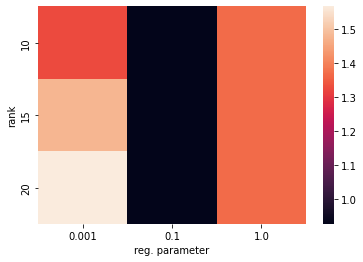

In [32]:
fig, ax = plt.subplots()
sns.heatmap(rmse_df, fmt=".4g")

In [33]:
# print(dir(pyspark))
# help(SparkSession)
# help(CrossValidator)
# help(StructType)
# help(IntegerType)
# help(movielens)
# help(start_or_get_spark)
# help(SparkRankingEvaluation)
# help(SparkRatingEvaluation)
# help(ALS)

# help(model.transform)
# dir(pyspark.ml.recommendation)

### References
1. Recommender Systems by Charu C. Aggarwal
1. Learning Spark 2.0 by Jules S. Damji, Brooke Wenig, Tathagata Das & Denny Lee
1. Collaborative Filtering for Implicit Feedback Datasets, by Yifan Hu, Yehuda Koren, Chris Volinsky
1. [Factorization Meets the Neighborhood: a Multifaceted Collaborative Filtering Model by Yehuda Koren](https://github.com/gpfvic/IRR/blob/master/Factorization%20meets%20the%20neighborhood-%20a%20multifaceted%20collaborative%20filtering%20model.pdf)
1. [Spark Programming Guide @ spark.apache.org](https://spark.apache.org/docs/latest/rdd-programming-guide.html)
1. [Spark Join Strategies @ towardsdatascience.com](https://towardsdatascience.com/strategies-of-spark-join-c0e7b4572bcf)
1. [Collaborative Filtering @ towardsdatascience.com](https://towardsdatascience.com/build-recommendation-system-with-pyspark-using-alternating-least-squares-als-matrix-factorisation-ebe1ad2e7679)